In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [63]:
AEP = pd.read_csv('C:\\Users\\ASUS\\Desktop\\Python\\AEP_hourly.csv\\AEP_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

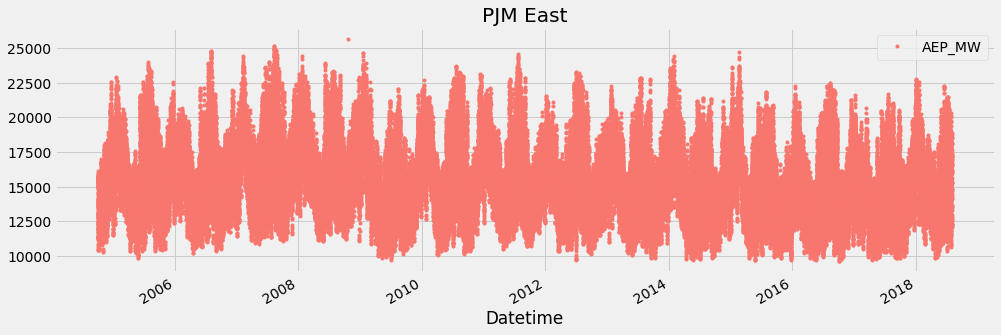

In [64]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
AEP.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

In [25]:
AEP.tail()

,AEP_MW
Datetime,
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0
2018-01-01 23:00:00,20415.0
2018-01-02 00:00:00,19993.0


In [65]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(AEP, label='AEP_MW')

features_and_target = pd.concat([X, y], axis=1)

In [66]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,AEP_MW
Datetime,,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,53,13478.0
2004-12-31 02:00:00,2,4,4,12,2004,366,31,53,12865.0
2004-12-31 03:00:00,3,4,4,12,2004,366,31,53,12577.0
2004-12-31 04:00:00,4,4,4,12,2004,366,31,53,12517.0
2004-12-31 05:00:00,5,4,4,12,2004,366,31,53,12670.0


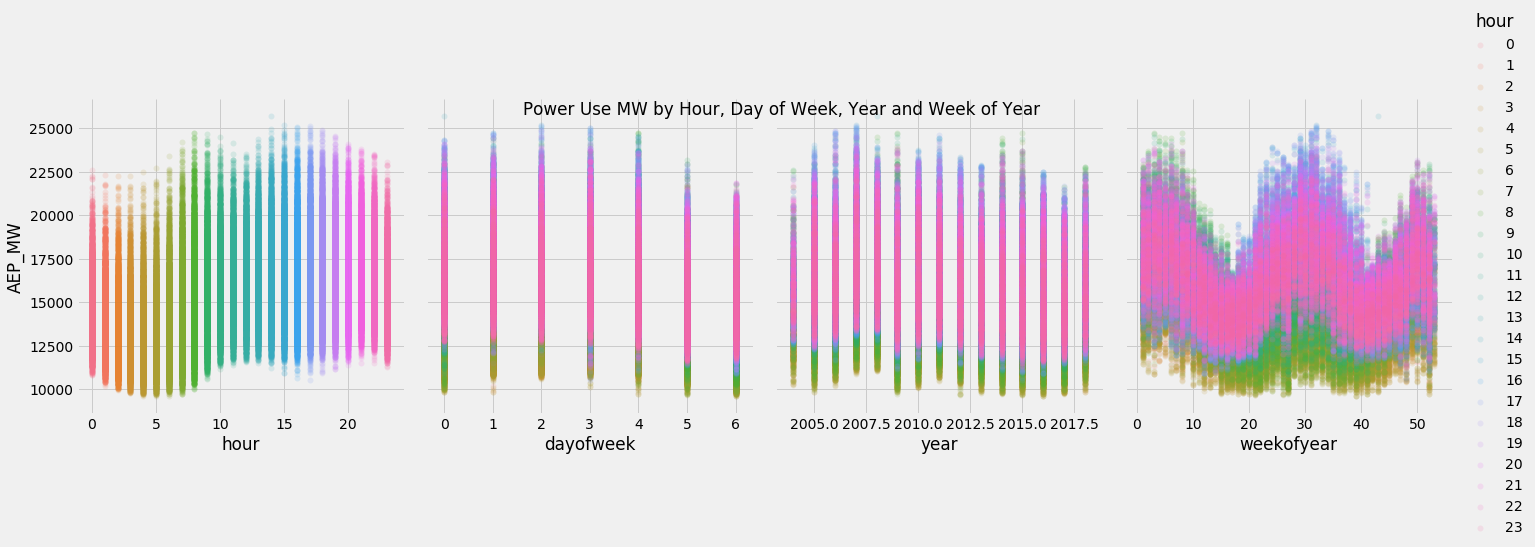

In [67]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='AEP_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [68]:
split_date = '01-Jan-2016'
AEP_train = AEP.loc[AEP.index <= split_date].copy()
AEP_test = AEP.loc[AEP.index > split_date].copy()

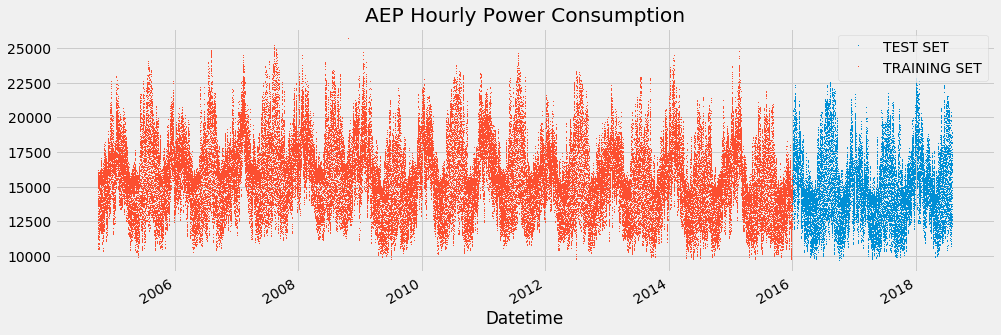

In [77]:
# Plot train and test so you can see where we have split
AEP_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(AEP_train.rename(columns={'AEP_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='AEP Hourly Power Consumption', style=',')
plt.show()

In [78]:
# Format data for prophet model using ds and y
AEP_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'AEP_MW':'y'}).head()

,ds,y
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [79]:
# Setup and train model and fit
model = Prophet()
model.fit(AEP_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'AEP_MW':'y'}))

C:\Users\ASUS\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [80]:
# Predict on training set with model
AEP_test_fcst = model.predict(df=AEP_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [81]:
AEP_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01 01:00:00,14568.484033,12246.205773,16252.450155,14568.484033,14568.484033,-427.287642,-427.287642,-427.287642,-1524.142266,...,475.530932,475.530932,475.530932,621.323692,621.323692,621.323692,0.0,0.0,0.0,14141.196391
1,2016-01-01 02:00:00,14568.439860,11686.658435,15476.419721,14568.439860,14568.439860,-1025.342195,-1025.342195,-1025.342195,-2113.570654,...,465.238956,465.238956,465.238956,622.989503,622.989503,622.989503,0.0,0.0,0.0,13543.097665
2,2016-01-01 03:00:00,14568.395687,11250.965295,15223.241825,14568.395687,14568.395687,-1372.662905,-1372.662905,-1372.662905,-2451.408013,...,454.063637,454.063637,454.063637,624.681472,624.681472,624.681472,0.0,0.0,0.0,13195.732782
3,2016-01-01 04:00:00,14568.351514,11206.567704,15078.807016,14568.351514,14568.351514,-1420.271393,-1420.271393,-1420.271393,-2488.564264,...,441.893297,441.893297,441.893297,626.399574,626.399574,626.399574,0.0,0.0,0.0,13148.080121
4,2016-01-01 05:00:00,14568.307341,11494.384321,15391.970809,14568.307341,14568.307341,-1135.948285,-1135.948285,-1135.948285,-2192.701013,...,428.608942,428.608942,428.608942,628.143786,628.143786,628.143786,0.0,0.0,0.0,13432.359056


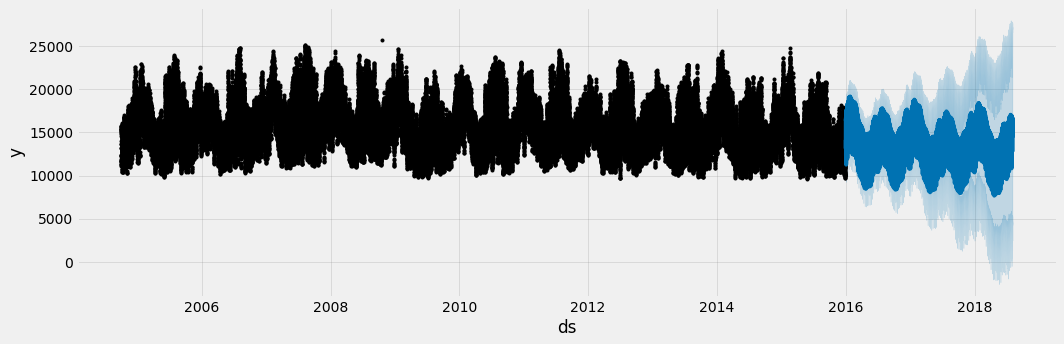

In [82]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(AEP_test_fcst,
                 ax=ax)
plt.show()

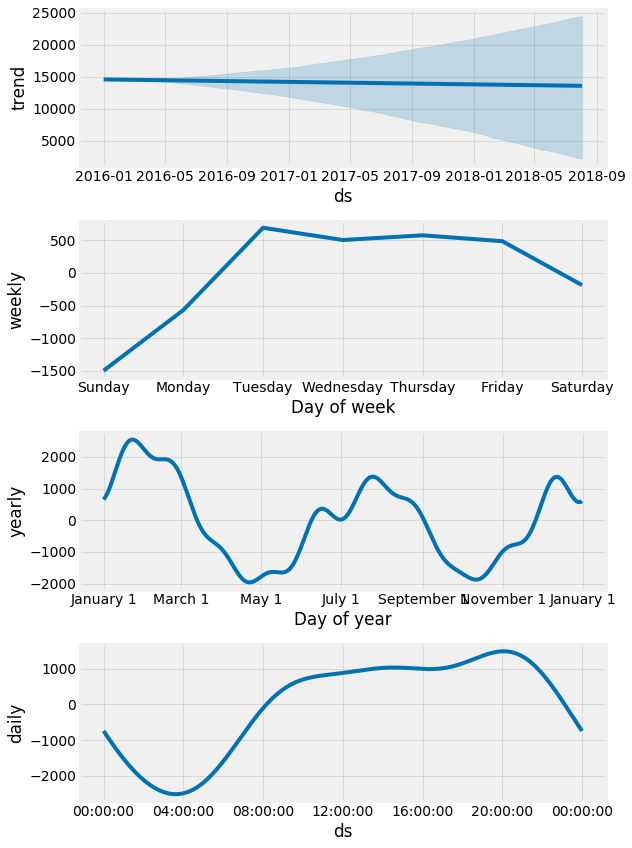

In [83]:
# Plot the components of the model
fig = model.plot_components(AEP_test_fcst)

# Compare Forecast to Actuals

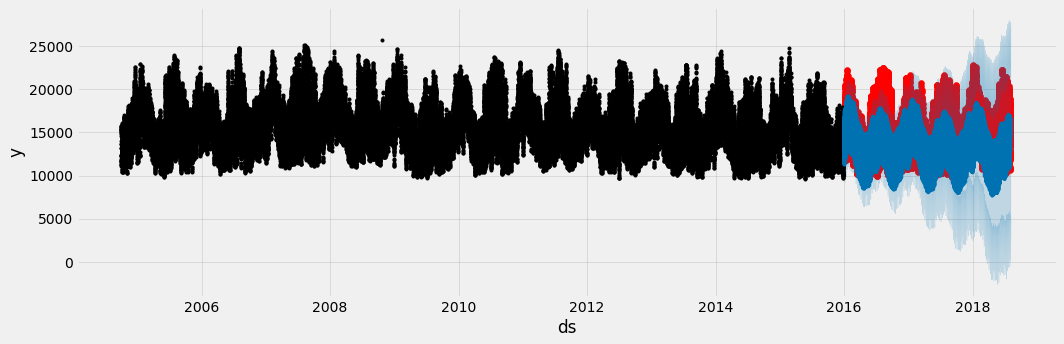

In [84]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(AEP_test.index, AEP_test['AEP_MW'], color='r')
fig = model.plot(AEP_test_fcst, ax=ax)

In [39]:
mean_squared_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst['yhat'])

6734410.670784444

In [87]:
np.sqrt(mean_squared_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst['yhat']))

2595.0743092991465

In [40]:
mean_absolute_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst['yhat'])

2039.5328332022918

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst['yhat'])

13.554308269689889

In [ ]:
Our MSE error is 6734410.670784444
Our RMSE error is 2595.0743092991465
Our MAE error is 2039.5328332022918 
Our MAPE error is 13.55%

In [88]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=AEP_train.index.min(),
                              end=AEP_train.index.max())
test_holidays = cal.holidays(start=AEP_test.index.min(),
                             end=AEP_test.index.max())

In [89]:
# Create a dataframe with holiday, ds columns
AEP['date'] = AEP.index.date
AEP['is_holiday'] = AEP.date.isin([d.date() for d in cal.holidays()])
holiday_df = AEP.loc[AEP['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['AEP_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2004-12-31 01:00:00,USFederalHoliday
1,2004-12-31 02:00:00,USFederalHoliday
2,2004-12-31 03:00:00,USFederalHoliday
3,2004-12-31 04:00:00,USFederalHoliday
4,2004-12-31 05:00:00,USFederalHoliday


In [90]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [91]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(AEP_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'AEP_MW':'y'}))

C:\Users\ASUS\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [92]:
# Predict on training set with model
AEP_test_fcst_with_hols = \
    model_with_holidays.predict(df=AEP_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

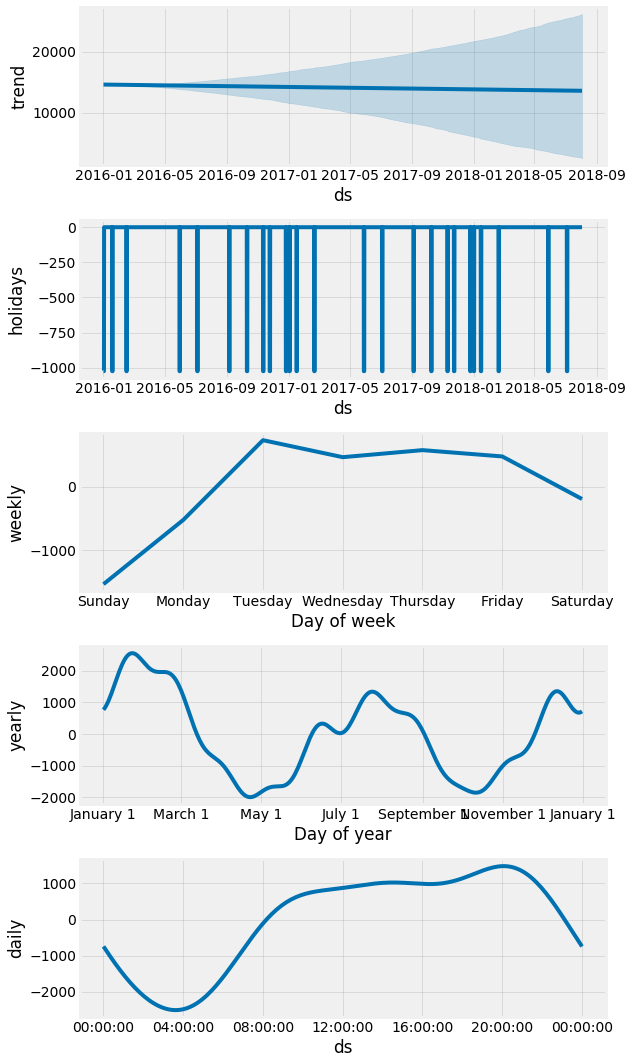

In [93]:
fig2 = model_with_holidays.plot_components(AEP_test_fcst_with_hols)

# Error Metrics with Holidays Added
Suprisingly the error has gotten worse after adding holidays.

In [94]:
mean_squared_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst_with_hols['yhat'])

6800591.995783664

In [95]:
np.sqrt(mean_squared_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst_with_hols['yhat']))

2607.7944696205764

In [96]:
mean_absolute_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst_with_hols['yhat'])

2049.709601768724

In [97]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=AEP_test['AEP_MW'],
                   y_pred=AEP_test_fcst_with_hols['yhat'])

13.619255703095872

In [ ]:
Our MSE error is 6800591.995783664
Our RMSE error is 2607.7944696205764
Our MAE error is 2049.709601768724
Our MAPE error is 13.61%

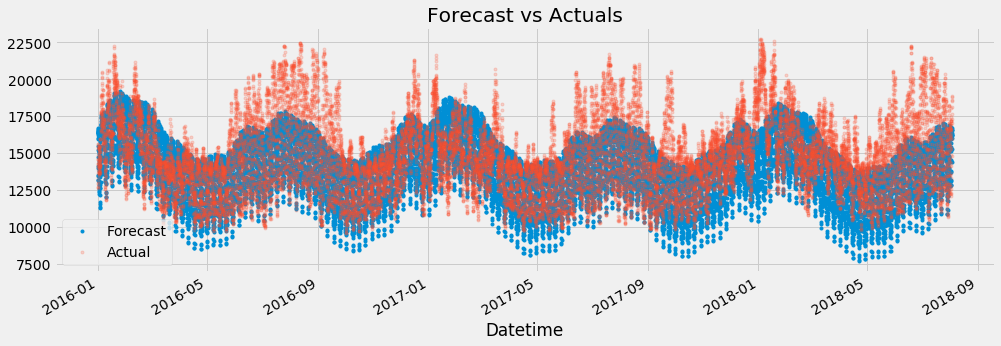

In [113]:
ax = AEP_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=10,
                                                 style='.')
AEP_test['AEP_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()